In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from torchvision.datasets import CIFAR10
import torch
import random

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.datasets.cifar10 import Cifar10


def plot_client_data(seeds, n_clients, alpha):
    train_data = CIFAR10(root='data', train=True, download=True)
    train_data.targets = torch.tensor(train_data.targets)
    dataset = Cifar10(num_workers=0, public_fraction=0.5)

    fig, ax = plt.subplots(len(settings_files), 1, figsize=(16, 10))

    for j, seed in enumerate(seeds):
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

        dataset.generate_client_data(n_clients=10, distribution="niid", alpha=alpha)
        local_indices = dataset.get_local_sets_indices()
        
        client_targets = [train_data.targets[indices].tolist() for indices in local_indices]
        n_classes = 10

        label_count_matrix = np.array([[np.sum(np.array(client_targets[i]) == c) for c in range(10)] for i in range(n_clients)])
        data_dict = {}
        for i in range(n_classes):
            data_dict[f"label_count{i}"] = label_count_matrix[:, i]

        df = pd.DataFrame(data_dict)

        df.plot(ax=ax[j], kind='bar', stacked=True, rot=0)
        ax[j].get_legend().remove()
    ax[0].legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], mode="expand", ncol=10, bbox_to_anchor=(0,1.02,1,0.15), loc="upper left")
    plt.show()

def plot_test_public_data():

    dataset = Cifar10(num_workers=0, public_fraction=0.5)
    public_indices = dataset.get_public_indices()

    test_data = CIFAR10(root='../data', train=False)
    train_data = CIFAR10(root='../data', train=True)
    train_data.targets = torch.tensor(train_data.targets)
    test_data.targets = torch.tensor(test_data.targets)
    test_public_targets = [test_data.targets.tolist()]
    test_public_targets.append(train_data.targets[public_indices].tolist())

    label_count_matrix = np.array([[np.sum(np.array(targets) == c) for c in range(10)] for targets in test_public_targets])

    n_classes = 10
    data_dict = {}
    for i in range(n_classes):
        data_dict[f"label_count{i}"] = label_count_matrix[:, i]

    fig, ax = plt.subplots(figsize=(12, 8))
    df = pd.DataFrame(data_dict, index=["Test data", "Public data"])
    df.plot(ax=ax, kind='bar', stacked=True, rot=0)
    ax.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], mode="expand", ncol=10, bbox_to_anchor=(0,1.01,1,0.1), loc="upper left")
    ax.tick_params(axis='both', which='major', labelsize=18)
    plt.show()    

def plot_client_training(settings_files, alg, weight_scheme, student_model=None, loss=None):    
    student_model = student_model + "_" if student_model is not None else ""
    loss = loss + "_" if loss is not None else ""

    dataset = settings_files[0].split('_')[0]
    
    fig, ax = plt.subplots(2, len(seeds), figsize=(15,6))
    for i, set in enumerate(settings_files):
        results_path = f"../results/{dataset}/{alg}/{set}"
        client_accs = []
        with open(f"{results_path}/client_accuracy.npy", "rb") as f:
            try:
                while True:
                    client_accs.extend([np.load(f)])
            except:
                pass

        client_losses = []
        with open(f"{results_path}/client_loss.npy", "rb") as f:
            try:
                while True:
                    client_losses.extend([np.load(f)])
            except:
                pass

        for accs in client_accs:
            ax[0][i].plot(accs)

        for losses in client_losses:
            ax[1][i].plot(losses)
    plt.show()  

def plot_student_results(settings_files, n_pub, model, loss, weight_scheme):
    fig, ax = plt.subplots(len(settings_files), len(n_pub), figsize=(15,15))
    test_acc_lists = [[] for _ in range(len(n_pub))]
    ensemble_test_acc = [[] for _ in range(len(settings_files))]
    dataset = settings_files[0].split('_')[0]

    for i, set in enumerate(settings_files):
        results_path = f"../results/{dataset}/feded/{set}/w{weight_scheme}_student_cifar10_{model}_{loss}"

        for j, n in enumerate(n_pub):
            with open(f"{results_path}_train_results_{n}.npy", "rb") as f:
                train_accs = np.load(f)
                train_losses = np.load(f)
                val_accs = np.load(f)
                val_losses = np.load(f)

            with open(f"{results_path}_test_results_{n}.npy", "rb") as f:
                test_results = np.load(f)

            ax[i][j].plot(train_accs)
            ax[i][j].plot(val_accs)
            ax[i][j].set_ylim([10,100])
            test_acc_lists[j].append(test_results[0])
            
        with open(f"../results/{dataset}/feded/{set}/w{weight_scheme}_ensemble_test_acc.npy", "rb") as f:
                ensemble_test_acc[i] = np.load(f)[0]
        
    plt.show()
    print("Test accuracy \n\n")
    print("{:<15} {:<10} {:<10} {:<10} {:<10} {:<10} | {:<10}".format('Run\Public size', n_pub[0], n_pub[1], n_pub[2], n_pub[3], n_pub[4], 'Ensemble'))
    for run in range(len(settings_files)):
        print("{:<15} {:<10} {:<10} {:<10} {:<10} {:<10} | {:<10} ".format(run, 
                                                  test_acc_lists[0][run],
                                                  test_acc_lists[1][run],
                                                  test_acc_lists[2][run],
                                                  test_acc_lists[3][run],
                                                               test_acc_lists[4][run],
                                                    ensemble_test_acc[run]))
    print("")
    print("{:<15} {:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f}".format('Mean',
                                                     np.mean(test_acc_lists[0]),
                                                     np.mean(test_acc_lists[1]),
                                                     np.mean(test_acc_lists[2]),
                                                     np.mean(test_acc_lists[3]),
                                                                np.mean(test_acc_lists[4]),
                                                                np.mean(ensemble_test_acc)))
    print("{:<15} {:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f}".format('Std',
                                                    np.std(test_acc_lists[0]),
                                                    np.std(test_acc_lists[1]),
                                                    np.std(test_acc_lists[2]),
                                                    np.std(test_acc_lists[3]),
                                                            np.std(test_acc_lists[4]),
                                                            np.std(ensemble_test_acc)))

def print_test_results(settings_files, alg):    
    #fig, ax = plt.subplots(1, 2, figsize=(15,6))
    dataset = settings_files[0].split('_')[0]
    test_acc_list = []
    for i, set in enumerate(settings_files):
        results_path = f"../results/{dataset}/{alg}/{set}"

        with open(f"{results_path}/fedavg_test_results.npy", "rb") as f:
            test_accs = np.load(f)
            test_losses = np.load(f)

        #ax[0].plot(test_accs)
        #ax[1].plot(test_losses)
        test_acc_list.append(test_accs[-1])
    # ax[0].set_ylabel("Accuracy")
    # ax[0].set_xlabel("Communication round")
    # ax[1].set_ylabel("Loss")
    # ax[1].set_xlabel("Communication round")
    #plt.show()
    print("{:<8} {:<10}".format('Run', 'Test accuracy'))
    for run in range(len(settings_files)):
        print("{:<8} {:<10}".format(run, test_acc_list[run]))
    print("")
    print("{:<8} {:<10.2f}".format('Mean', np.mean(test_acc_list)))
    print("{:<8} {:<10.2f}".format('Std', np.std(test_acc_list)))
                                                

In [2]:
distribution = "niid0.1"
seeds = [0,2,3,4,5,6,7,8,9,10]
n_clients = 10
model = "cifar10_resnet18"
settings_files = [f"{model}_c{n_clients}_{distribution}_s{i}" for i in seeds]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


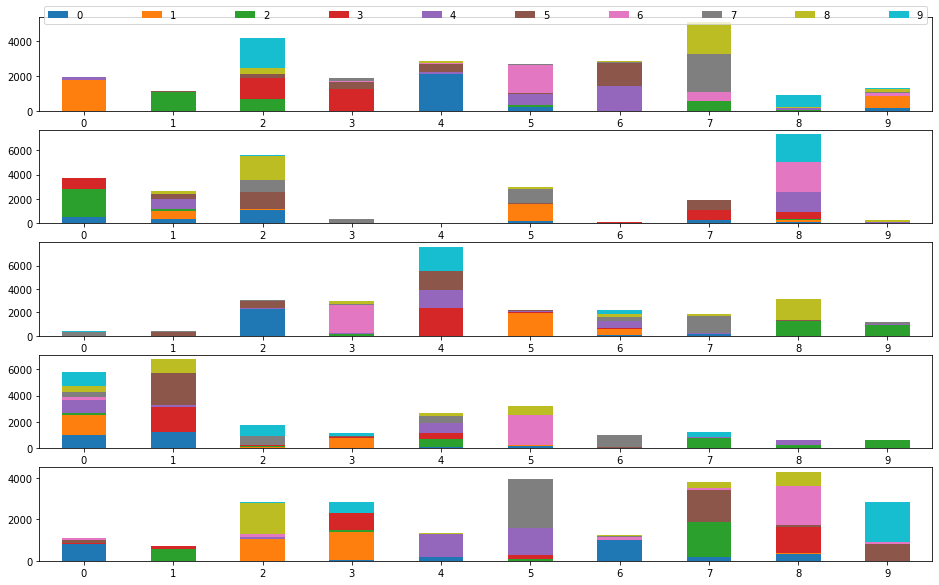

In [12]:
plot_client_data(seeds, n_clients, 0.1)

Files already downloaded and verified
Files already downloaded and verified


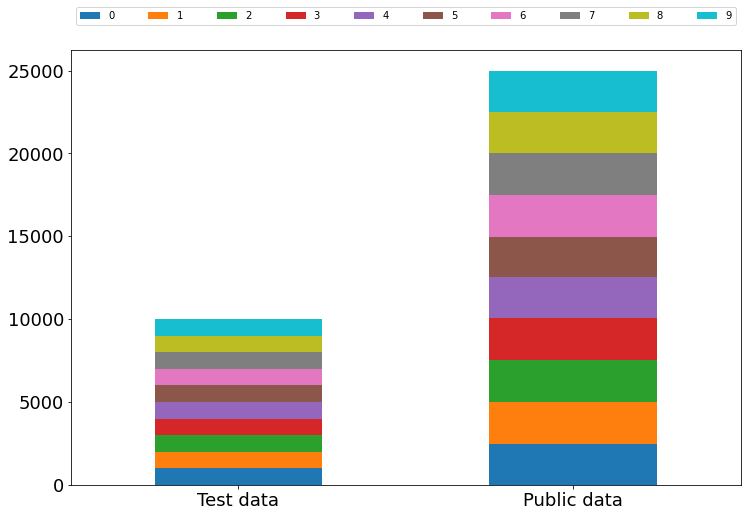

In [15]:
plot_test_public_data()

# FedAVG
```
class Cifar10_Resnet(nn.Module):
    def __init__(self):
        super(Cifar10_Resnet, self).__init__()
        base = resnet18(pretrained=False)
        self.base = nn.Sequential(*list(base.children())[:-1])
        in_features = base.fc.in_features
        self.drop = nn.Dropout()
        self.final = nn.Linear(in_features, 10)
    
    def forward(self,x):
        x = self.base(x)
        x = self.drop(x.view(-1,self.final.in_features))
        return self.final(x)
```
Centralized model ~ 56 % accuracy

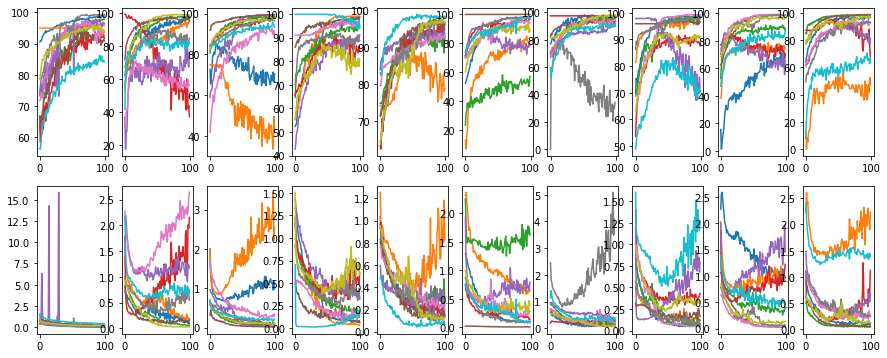

In [3]:
plot_client_training(settings_files, "fedavg", 0)

In [4]:
print_test_results(settings_files, "fedavg")

Run      Test accuracy
0        37.49     
1        42.26     
2        36.28     
3        40.05     
4        35.87     
5        40.24     
6        30.86     
7        39.85     
8        43.9      
9        38.92     

Mean     38.57     
Std      3.49      


In [5]:
print_test_results(settings_files, "fedprox")

Run      Test accuracy
0        37.28     
1        43.53     
2        34.95     
3        41.13     
4        35.75     
5        39.88     
6        29.39     
7        40.04     
8        43.13     
9        39.25     

Mean     38.43     
Std      4.04      


# FedED
```
class Mnist_Cnn2(nn.Module):
    def __init__(self):
        super(Mnist_Cnn2, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, 1, 2)
        self.conv2 = nn.Conv2d(16, 32, 5, 1, 2)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        
loss = nn.MSELoss()
```

$$
  \mathbf{\hat{z}} = \sum_{k\in\mathcal{K}_t} \omega_k \mathbf{z}^k, \quad \omega^k = \frac{N^k}{\sum_{k\in\mathcal{K}_t} N^k}
$$

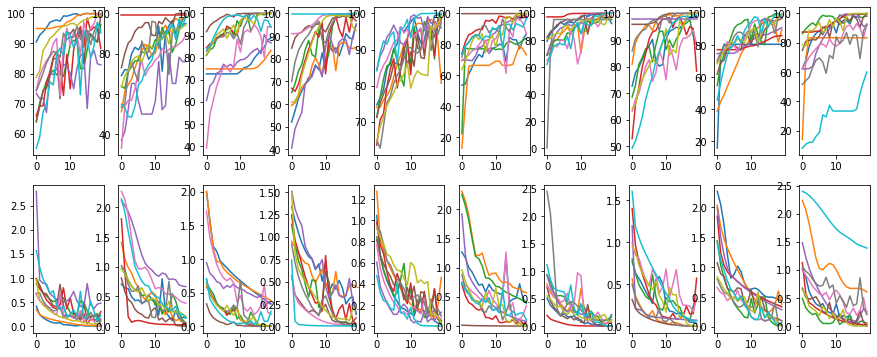

In [6]:
plot_client_training(settings_files, "feded", 0, "resnet18", "mse")

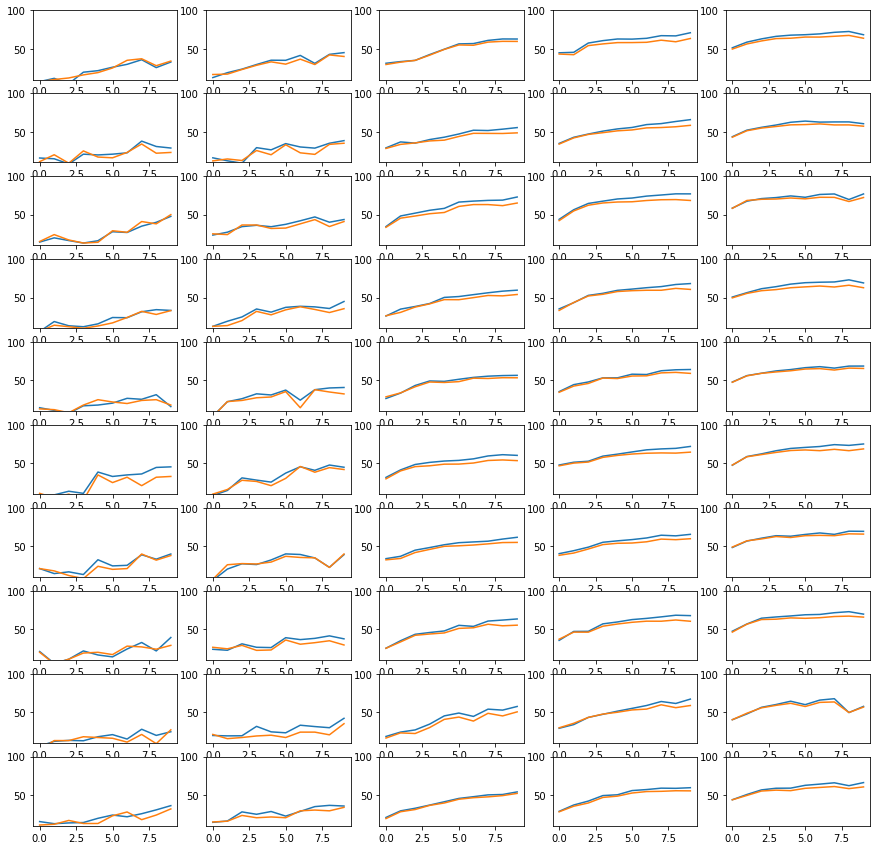

Test accuracy 


Run\Public size 500        1000       5000       10000      25000      | Ensemble  
0               16.29      21.18      28.53      32.29      34.86      | 36.24      
1               18.54      23.72      31.33      38.68      39.04      | 41.79      
2               18.85      16.27      27.45      29.92      33.04      | 32.32      
3               16.08      22.26      30.14      35.85      37.58      | 43.33      
4               15.11      21.21      30.43      32.98      38.76      | 38.02      
5               17.03      19.12      26.75      33.85      37.74      | 38.91      
6               15.15      18.59      27.31      30.45      36.43      | 33.68      
7               16.14      20.27      31.96      37.36      38.51      | 40.01      
8               16.28      22.91      33.63      39.61      39.08      | 41.97      
9               19.97      23.76      32.22      37.51      41.81      | 42.4       

Mean            16.94      20.93      29.98     

In [7]:
plot_student_results(settings_files, [500, 1000, 5000, 10000, 25000], "resnet18", "mse", 0)

# FedED weight scheme 1

$$
  \mathbf{\hat{z}}_c = \sum_{k\in\mathcal{K}_t} \omega^c_k \mathbf{z}^k_c, \quad \omega^k_c = \frac{N_c^k}{\sum_{k\in\mathcal{K}_t} N_c^k}
$$

In [36]:
#plot_client_training("mnist", "feded", 1, "cnn2")

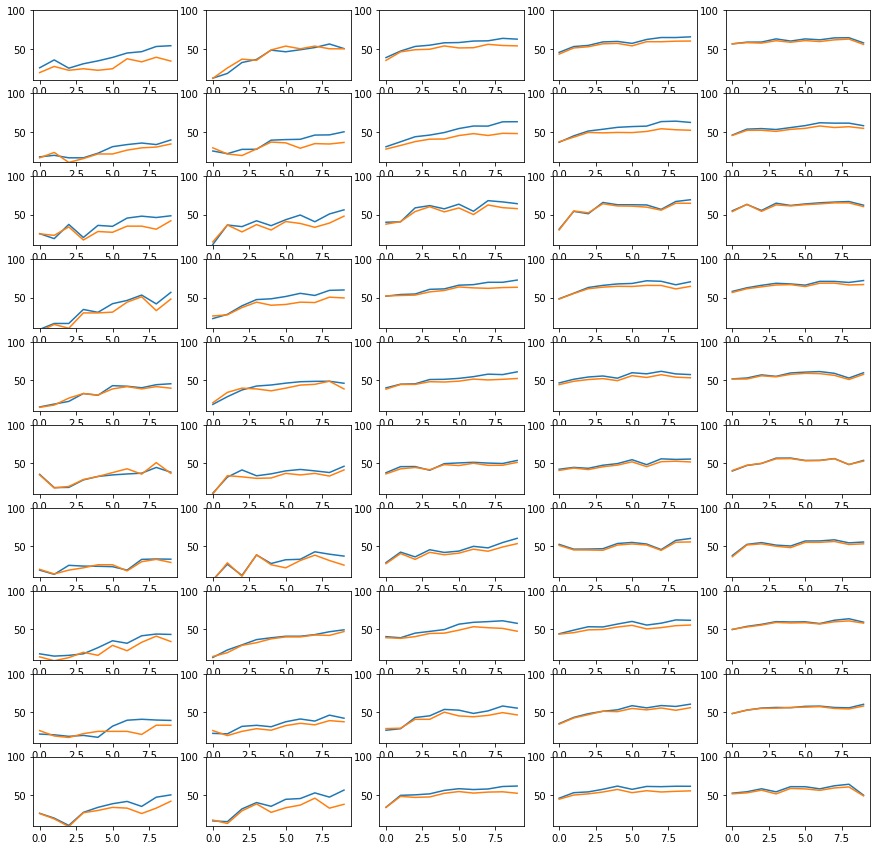

Test accuracy 


Run\Public size 500        1000       5000       10000      25000      | Ensemble  
0               23.66      29.7       36.63      39.12      34.71      | 39.52      
1               18.03      23.07      35.18      36.87      39.43      | 42.83      
2               22.8       27.89      30.48      31.34      32.76      | 34.18      
3               17.9       22.51      31.45      32.44      34.95      | 39.99      
4               23.62      26.84      36.63      37.88      40.03      | 39.35      
5               11.77      19.68      20.28      24.27      24.06      | 29.28      
6               18.93      19.84      25.01      22.16      31.16      | 25.83      
7               25.73      29.05      38.26      38.18      41.48      | 42.73      
8               20.52      26.71      37.33      40.36      42.92      | 43.63      
9               25.11      30.59      39.44      40.87      33.4       | 39.98      

Mean            20.81      25.59      33.07     

In [8]:
plot_student_results(settings_files, [500, 1000, 5000, 10000, 25000], "resnet18", "mse", 1)

# FedED weight scheme 2

1. Träna autoencoder $H_k$ på privat data $\mathcal{D}_k$.
2. För varje publikt dataexempel $x_j$, notera loss
$$ l_k(x_j) = MSE(H_k(x_j), x_j). $$
3. Ange vikt 
$$\omega^j_k = \frac{1}{l_k(x_j)^6}.$$
3. Bilda viktat medelvärde för logits med aktiva klienter $\mathcal{K}_t$
$$
  \mathbf{\hat{z}}_j = \sum_{k\in\mathcal{K}_t} \omega^j_k \mathbf{z}^j_k. %\quad \omega^k_c = \frac{N_c^k}{\sum_{k\in\mathcal{K}_t} N_c^k}
$$
4. Normalisera.

Student loss: 
$$\mathbf{z}_j = F_S(x_j) \qquad MSE(\mathbf{z}_j, \mathbf{\hat{z}}_j)$$
<!-- $$
  \mathbf{\bar{z}}_c = \sum_{k\in\mathcal{K}_t} N_c^k \mathbf{z}^k_c \\
  \mathbf{\hat{z}}_c = \frac{\mathbf{\bar{z}}_c}{\sum_c \mathbf{\bar{z}}_c}
$$ -->

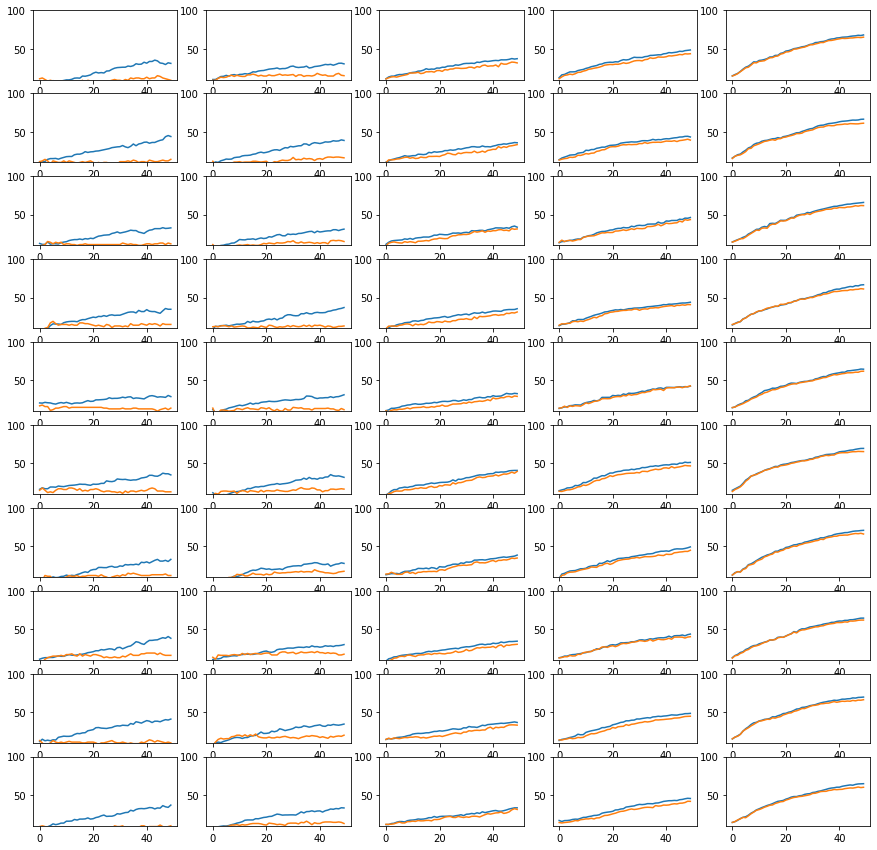

Test accuracy 


Run\Public size 500        1000       5000       10000      25000      | Ensemble  
0               11.77      12.53      17.93      23.22      34.91      | 39.27      
1               11.59      12.44      18.98      22.07      36.92      | 41.08      
2               11.3       12.89      18.82      24.64      34.11      | 38.38      
3               11.72      12.3       17.64      23.28      37.08      | 44.02      
4               11.67      12.41      19.26      20.29      33.6       | 39.12      
5               11.35      12.49      16.55      23.16      34.24      | 39.72      
6               11.99      11.74      18.48      23.92      34.6       | 38.61      
7               11.37      12.08      18.84      22.3       35.67      | 38.97      
8               12.31      12.71      20.7       25.92      39.78      | 43.6       
9               11.13      12.13      18.7       25.56      37.55      | 40.95      

Mean            11.62      12.37      18.59     

In [9]:
plot_student_results(settings_files, [500, 1000, 5000, 10000, 25000], "resnet18", "mse", 2)


Student loss: 
$$CE(\mathbf{t}_j, \mathbf{\hat{t}}_j)$$

FileNotFoundError: [Errno 2] No such file or directory: '../results/cifar10/feded/cifar10_resnet18_c10_niid0.1_s0/w2_student_cifar10_cnn2_ce_train_results_500.npy'

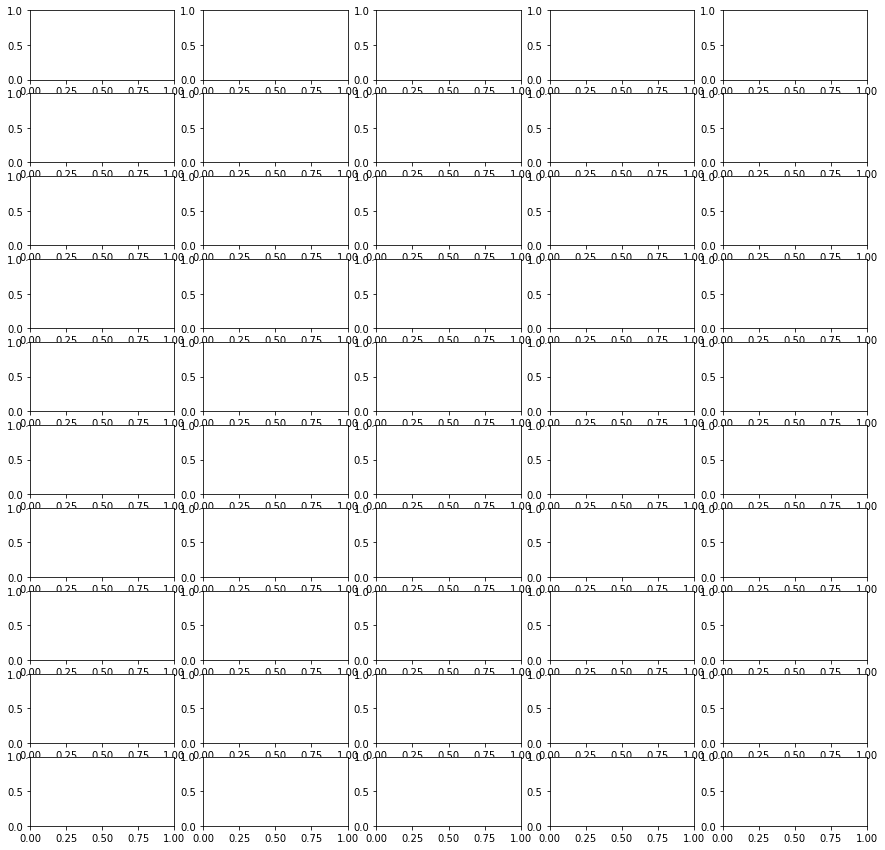

In [10]:
plot_student_results(settings_files, [500, 1000, 5000, 15000, 30000], "cnn2", "ce", 2)